In [1]:
#!pip install ipympl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display
%matplotlib widget

## **1. Minimization of a convex non-differentiable function**

### **1.1 Removing the non-differentiability with an auxiliary variable**

We will minimize a convex non-differentiable function f(x). As we saw in class, we need to remove the non-differentiability using an auxilary variable. Following the pdf of the lab, our f(x) becomes equivalent to maximine another function G(x,y) with respect to y. Since we wanted to minimize f(x), is we found that is the same the same as min(x) max(y) G(x,y). (The notation is not perfectly writen but is just for having a little summary of what are we going to do).

Now, observe that G(x,y) is concave for any fixed x, and convex for any fixed y. Thanks to this, G(x,y) has a saddle point and solving it is the same as minimizing our original function f(x).

To solve it we make use of the duality gap: in the saddle point max(y)min(x)G(x,y)= min(x)max(y)G(x,y), so we can solve any of this two problems to find our saddle point.

#### **1. Run toy_saddle_points() and determine which of the functions displayed presents a saddle point and which do not.**

First at all we will study the function below, which plots 4 defined functions and it's level curves.

In [2]:
def toy_saddle_points():
    # Define the grid
    start = -5
    stop = 5
    step = .05
    x = np.arange(start = start, stop = stop + step, step = step)
    y = np.arange(start = start, stop = stop + step, step = step)
    
    # Create the mesh grid
    x, y = np.meshgrid(x, y)
    
    # ============================ #
    # FIRST FUNCTION
    # ============================ #
    # Calculate the function
    f1 = np.power(x, 2) - np.power(y, 2)

    # Plot it
    fig = plt.figure(num = 1, figsize = (14, 8))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(x, y, f1,
                   cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
    ax.set_title("First function [ x^2 - y^2 ]")
    ax = fig.add_subplot(1, 2, 2)
    ax.contour(x, y, f1, 
              corner_mask = False, levels = 150, 
               linewidths=(1,), cmap = cm.coolwarm)
    
    # ============================ #
    # SECOND FUNCTION
    # ============================ #
    # Calculate the function
    f2 = 2 * x + y

    # Plot it
    fig = plt.figure(num = 2, figsize = (14, 8))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(x, y, f2,
                   cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
    ax.set_title("Second function [2x + y]")
    ax = fig.add_subplot(1, 2, 2)
    ax.contour(x, y, f2, 
              corner_mask = False, levels = 150, 
               linewidths=(1,), cmap = cm.coolwarm)
    
    # ============================ #
    # THIRD FUNCTION
    # ============================ #
    # Calculate the function
    f3 = np.power(x, 2) + np.power(y, 2)

    # Plot it
    fig = plt.figure(num = 3, figsize = (14, 8))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(x, y, f3,
                   cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
    ax.set_title("Third function [ x^2 + y^2 ]")
    ax = fig.add_subplot(1, 2, 2)
    ax.contour(x, y, f3, 
              corner_mask = False, levels = 150, 
               linewidths=(1,), cmap = cm.coolwarm)
    
    # ============================ #
    # FOURTH FUNCTION
    # ============================ #
    # Calculate the function
    f4 = np.cos((3 / 5) * (x + y)) + 0.25 * x

    # Plot it
    fig = plt.figure(num = 4, figsize = (14, 8))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(x, y, f4,
                   cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
    ax.set_title("Fourth function [cos(3/5 * (x + y)) + 0.25 * x]")
    ax = fig.add_subplot(1, 2, 2)
    ax.contour(x, y, f4, 
              corner_mask = False, levels = 150, 
               linewidths=(1,), cmap = cm.coolwarm)
    
    

Without entering in details the code is pretty straightforward to follow:

    We have 4 functions: x^2 - y^2, 2x + y, x^2 + y^2, cos(3/5 * (x + y)) + 0.25 * x.
    Each function is defined and then using some matplot functions it is plotted with it's corresponding contour.

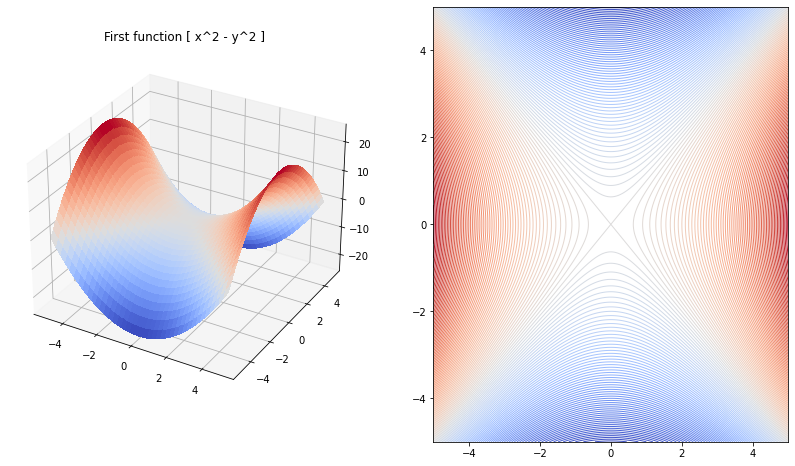

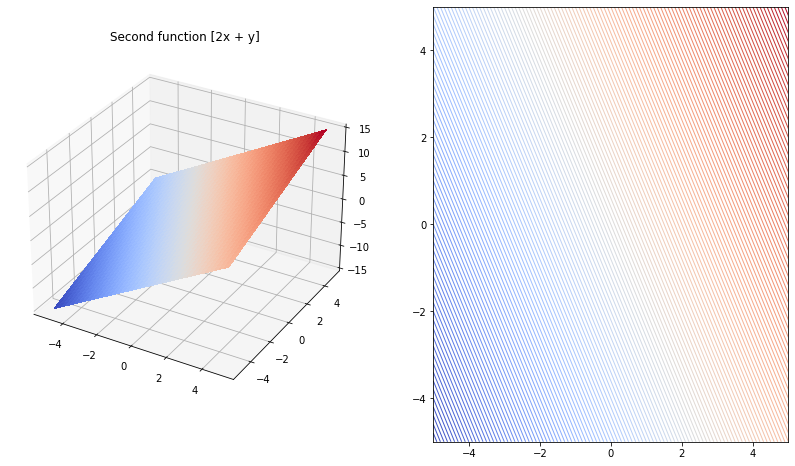

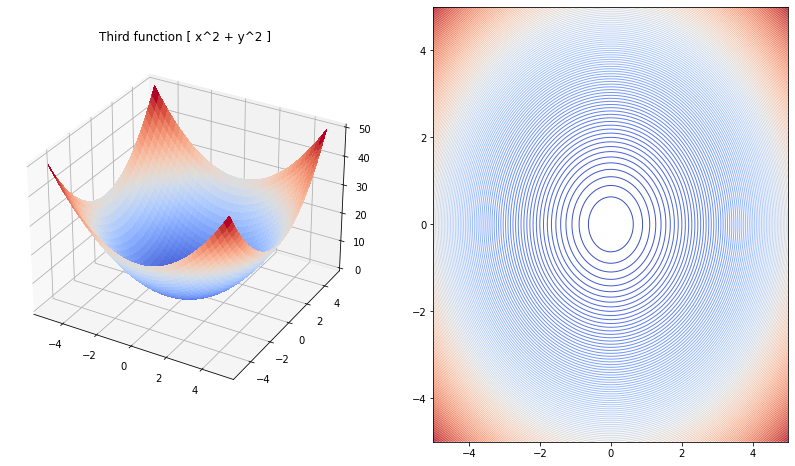

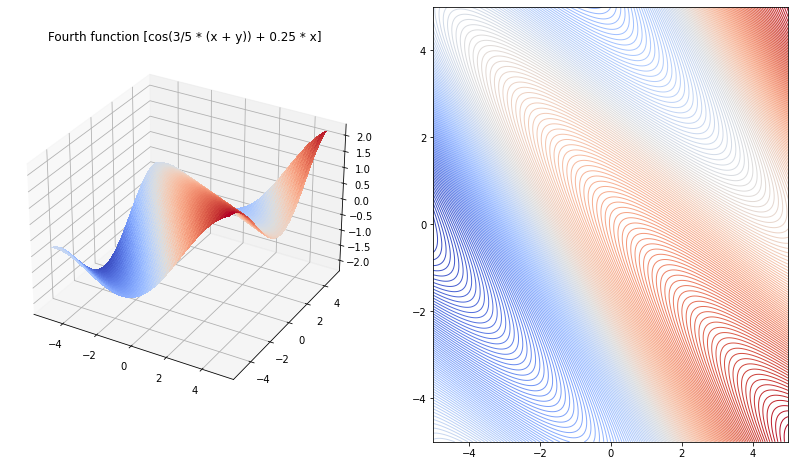

In [7]:
%matplotlib inline
toy_saddle_points()

A saddle point is defined a point which is a minimum in the direction of one variable and a maximum in the direction of another. Therefore knowing this:

    -First function: Clearly has a saddle point in the point (0,0)
    
    -Second function: No saddle points (it has no stationary points since it has a monotonic increase)
    
    -Third function: No saddle points (it's a convex funtcion with a global minimum easy to see)
    
    -Forth function: No saddle points (althoug in one direction we can observe infinite maximums and minimums, the better we can find looking at other directions of these points is a straight line which doesn't have stationary points)

We will focus on solving the max-min problem in two ways:

    -First solve the min part resulting in a function of y (dual function), and then max this dual function which is equivalent to mininimize f(x) (the primal function)
    
    -Primal-dual approach: we do gradient ascent in one variable and gradient descent in another. Note that the gradient ascent is projected since we have constraints on y.

### **1.2 The primal-dual problem: finding a saddle point**

First we will approach with the second option

#### **3. Complete the function toy_primal_dual. Follow the comments provided in the code.**

In [3]:
def toy_primal_dual(A, b, lambda_, x, pd_prms, fig = None, ax1 = None, ax2 = None, ax3 = None, ax4 = None):
    """
    toy_primal_dual - minimizes a non-differentiable function f:R^n-:param R of the
    form 

       f(x) = ||Ax|| + 1/(2*lambda)*|| x - b ||^2. 

    using a form of duality to remove the non-differentiability. It transforms
    the problem into a max-min problem, solved numerically with a gradient
    descent and gradient ascent.

    [x,y] = toy_primal_dual (A, b, lambda, x, pd_prms) 

    :param A       : mxn matrix (n is the dimension of x)
    :param b       : nx1 vector
    :param lambda  : weight between two terms
    :param x       : nx1 initial condition for primal variable
    :param pd_prms : a structure with the dual maximization parameters. Needs to have
                     the following fields:
                     
                        :param delta     : dual gradient ascent step size
                        :param theta     : primal gradient descent step size
                        :param max_iters : maximum number of iterations
                        :param tolerance : tolerance for the stopping condition (it stop when 
                                           the norm of the gradient is below the tolerance)

    :return x     : primal value found (nx1)
    :return y     : dual   value found (mx1)
    :return fps   : evolution of the primal function (total_iters x 1 vector)
    :return fds   : evolution of the dual function (total_iters x 1 vector)
    """
    # Get all the params
    tolerance = pd_prms.get("tolerance")
    max_iters = pd_prms.get("max_iters")
    delta     = pd_prms.get("delta")
    theta     = pd_prms.get("theta")
    
    # initialize dual to 0
    y = 0 * x

    # vectors with function values
    fps = []
    fds = []

    # begin projected gradient ascent
    it = 0
    dual_gap = np.inf
    print(dual_gap > tolerance)
    print(it < max_iters)
    while (dual_gap > tolerance) and (it < max_iters):
        # Increment the iteration
        it = it + 1
        
        # Save the current value, just for displaying
        x_old = x
        y_old = y

        # TODO: update x by gradient descent with step theta
        x = x_old - theta*(A.T@y_old + (x_old-b)/lambda_)

        # TODO: update y by gradient ascent with step delta
        y = y_old + delta*A@x
        
        # TODO: project y over constraint set
        y = y/max(1,np.linalg.norm(y)) 

        # compute primal energy
        P_data = (1 / 2 / lambda_) * np.power(x - b, 2).sum()
        P = np.linalg.norm(np.dot(A, x)) + P_data

        # compute dual energy
        Aty = np.dot(A.T, y)
        D = np.dot(b.T, Aty) - lambda_ / 2 * np.power(Aty, 2).sum()

        # compute primal dual energy
        PD = np.dot(np.dot(A, x).T, y) + P_data

        # TODO: update dual gap
        dual_gap = P - D

        # Update the arrays
        fps.append(P)
        fds.append(D)
        
        # Update the plot
        if fig is not None:
            # ---- 
            if x.shape[0] == 2 and x.shape[1] == 1:
                ax1.plot([x_old[0, 0], x[0, 0]], 
                         [x_old[1, 0], x[1, 0]], "-k")
                ax2.plot([y_old[0, 0], y[0, 0]], 
                         [y_old[1, 0], y[1, 0]], "-k")
                ax3.scatter(x[0, 0], x[1, 0], P, marker = "o", color = "k")
                ax4.scatter(y[0, 0], y[1, 0], D, marker = "o", color = "k")
                
            elif x.shape[0] == 1 and x.shape[1] == 1:
                ax1.plot(x, P, marker = '.', color = "k")
                ax2.plot(y, D, marker = '.', color = "k")
                ax3.plot([x_old[0, 0], x[0, 0]], 
                         [y_old[0, 0], y[0, 0]], "-k")
                ax4.scatter(x, y, PD, marker = "o", color = "k")
                
            else:
                pass
            # ----
            display.clear_output(wait=True)
            display.display(fig) 
        
        # Print the current values
        print('[It. {0} of {1}] |P( x(k) ) - D( y(k) )| = {2}'.format(it, max_iters,dual_gap))

    return fps, fds

### **1.3 The dual problem: constrained maximization**

Now we will try to solve it with our first option described before(solving for the dual function).

#### **6. Complete the function toy_dual. Follow the comments provided in the code.**

In [4]:
def toy_dual(A, b, lambda_, d_prms, fig = None, ax1 = None, ax2 = None, ax3 = None, ax4 = None):
    """
    toy_dual - minimizes a non-differentiable function f:R^n-:param R of the form 

       f(x) = ||Ax|| + 1/2/lambda*|| x - b ||^2. 

    using a form of duality to remove the non-differentiability. It transforms
    the problem into a max-min problem, eliminates the primal by solving the min
    analytically, and solves the max numerically with a gradient ascent.

    [x,xi] = toy_dual (A, b, lambda, d_prms) 

    :param A      : mxn matrix (n is the dimension of x)
    :param b      : nx1 vector
    :param lambda : weight between two terms
    :param d_prms : a structure with the dual maximization parameters. Needs to have
                    the following fields:
                   :param delta     : gradient ascent step size
                   :param max_iters : maximum number of iterations
                   :param tolerance : tolerance for the stopping condition (it stop when 
                                      the norm of the gradient is below the tolerance)

    :return x     : primal value found (nx1)
    :return xi    : dual   value found (mx1)
    :return fps   : evolution of the primal function (total_iters x 1 vector)
    :return fds   : evolution of the dual function (total_iters x 1 vector)
    """
    # Get all the params
    tolerance = d_prms.get("tolerance")
    max_iters = d_prms.get("max_iters")
    delta     = d_prms.get("delta")
    
    # Initialization
    y = np.zeros((len(A), 1))
    
    # TODO: Initialize x
    x = b - lambda_*A.T@y

    # vectors with function values
    fps = []
    fds = []

    # begin projected gradient ascent
    it = 0
    dual_gap = np.inf
    while (dual_gap > tolerance) and (it < max_iters):
        # Increment the iteration
        it = it + 1
        
        # Save the current value, just for displaying
        y_old = y

        # TODO: update y by gradient ascent with step delta
        y = y_old + delta*A@x
        
        # project y over constraint set
        y= y/max(1, np.linalg.norm(y))
        
        # TODO: compute primal variable as x^*(xi)
        x_old = x
        x= b-lambda_*A.T@y
        
        # compute primal energy
        P_data = (1 / 2 / lambda_) * np.power(x - b, 2).sum()
        P = np.linalg.norm(np.dot(A, x)) + P_data

        # compute dual energy
        Aty = np.dot(A.T, y)
        D = np.dot(b.T, Aty) - lambda_ / 2 * np.power(Aty, 2).sum()

        # compute primal dual energy
        PD = np.dot(np.dot(A, x).T, y) + P_data

        # TODO: update dual gap
        dual_gap = P-D

        # Update the arrays
        fps.append(P)
        fds.append(D)
        
        # Update the plot
        if fig is not None:
            # ---- 
            if x.shape[0] == 2 and x.shape[1] == 1:
                ax1.plot([x_old[0, 0], x[0, 0]], 
                         [x_old[1, 0], x[1, 0]], "-k")
                ax2.plot([y_old[0, 0], y[0, 0]], 
                         [y_old[1, 0], y[1, 0]], "-k")
                ax3.scatter(x[0, 0], x[1, 0], P, marker = "o", color = "k")
                ax4.scatter(y[0, 0], y[1, 0], D, marker = "o", color = "k")
                
            elif x.shape[0] == 1 and x.shape[1] == 1:
                ax1.plot(x, P, marker = '.', color = "k")
                ax2.plot(y, D, marker = '.', color = "k")
                ax3.plot([x_old[0, 0], x[0, 0]], 
                         [y_old[0, 0], y[0, 0]], "-k")
                ax4.scatter(x, y, PD, marker = "o", color = "k")
                
            else:
                pass
            # ----
            display.clear_output(wait=True)
            display.display(fig)  
        
        # Print the current values
        print('[It. {0} of {1}] |P( x(k) ) - D( y(k) )| = {2}'.format(it, max_iters,dual_gap))

    return fps, fds

At the beginning there is some useful information regarding the parematers needed for the algorithms and what information will store the return variables, so we can interpret this information in case we need it.

Both approaches are finally ready to be implemented and tested with some real examples.

#### **7. Run the functions toy_problem_R1 and toy_problem_R2. Explain the plots that are displayed in each case. Try different parameters as suggested in the comments in the code.**

In [7]:
def toy_problem_r1():
    # vector x to plot primal function
    x = np.matrix(np.arange(start = -5, stop = 5.01, step = .01))
    pmg_sz = len(x)

    # vector y to plot dual function
    y = np.matrix(np.arange(start = -1.1, stop = 1.1, step = .01))
    dmg_sz = len(y)

    # parameters of primal function
    A = np.identity(n = 1)
    b = np.matrix([-6])
    lambda_ = 3  # TRY also lambda_ = 10

    # compute primal function on x
    Ax = A * x
    E1 = np.sqrt(np.power(Ax, 2))
    E2 = np.power(x - np.tile(b, [1, pmg_sz]), 2)
    E  = E1 + (1 / (2 * lambda_)) * E2

    # compute dual function on y
    Aty = A.T * y
    D = np.dot(b.T, Aty) - lambda_ / 2 * np.power(Aty, 2)
    D = np.where(np.power(y, 2) > 1, np.nan, D)

    # compute primal-dual function on a primal-dual grid
    X, Y = np.meshgrid(x,y) # this is a primal-dual grid
    pdmg_sz = len(X)

    PD = np.tile(E2, [dmg_sz, 1]) / (2 * lambda_) + y.T * Ax
    PD = np.where(np.power(Y, 2) > 1, np.nan, PD)

    # ------- #
    # PLOT 
    # ------- #
    # Make the plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 8))
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    ax1.plot(np.array(x)[0], np.array(E)[0])
    ax2.plot(np.array(y)[0], np.array(D)[0])
    ax3.contour(X, Y, PD, 
            corner_mask = False, levels = 150, 
            linewidths=(1,), cmap = cm.coolwarm)
    ax4.plot_surface(X, Y, PD, cmap=cm.coolwarm,
                     linewidth=0, antialiased=False, 
                     vmax=1)
    ax1.set_title("Primal")
    ax2.set_title("Dual")
    ax3.set_title("Primal Dual")
    ax4.set_title("Primal Dual")
    
    # primal dual ----------------------------------------------
    x0 = np.matrix([3])
    pd_prms = {"delta": 0.05,
               "theta": 0.5,
               "max_iters": 1000,
               "tolerance": 1e-8}
    fps, fds = toy_primal_dual(A, b, lambda_, x0, pd_prms, fig, ax1, ax2, ax3, ax4)

    # dual ----------------------------------------------
    input("Press Enter to continue...")
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 8))
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    ax1.plot(np.array(x)[0], np.array(E)[0])
    ax2.plot(np.array(y)[0], np.array(D)[0])
    ax3.contour(X, Y, PD, 
            corner_mask = False, levels = 150, 
            linewidths=(1,), cmap = cm.coolwarm)
    ax4.plot_surface(X, Y, PD, cmap=cm.coolwarm,
                     linewidth=0, antialiased=False, 
                     vmax=1)
    ax1.set_title("Primal")
    ax2.set_title("Dual")
    ax3.set_title("Primal Dual")
    ax4.set_title("Primal Dual")
    d_prms = {"delta": 2e-2,
              "max_iters": 1000,
              "tolerance": 1e-8}
    fps, fds = toy_dual(A, b, lambda_, d_prms, fig, ax1, ax2, ax3, ax4)

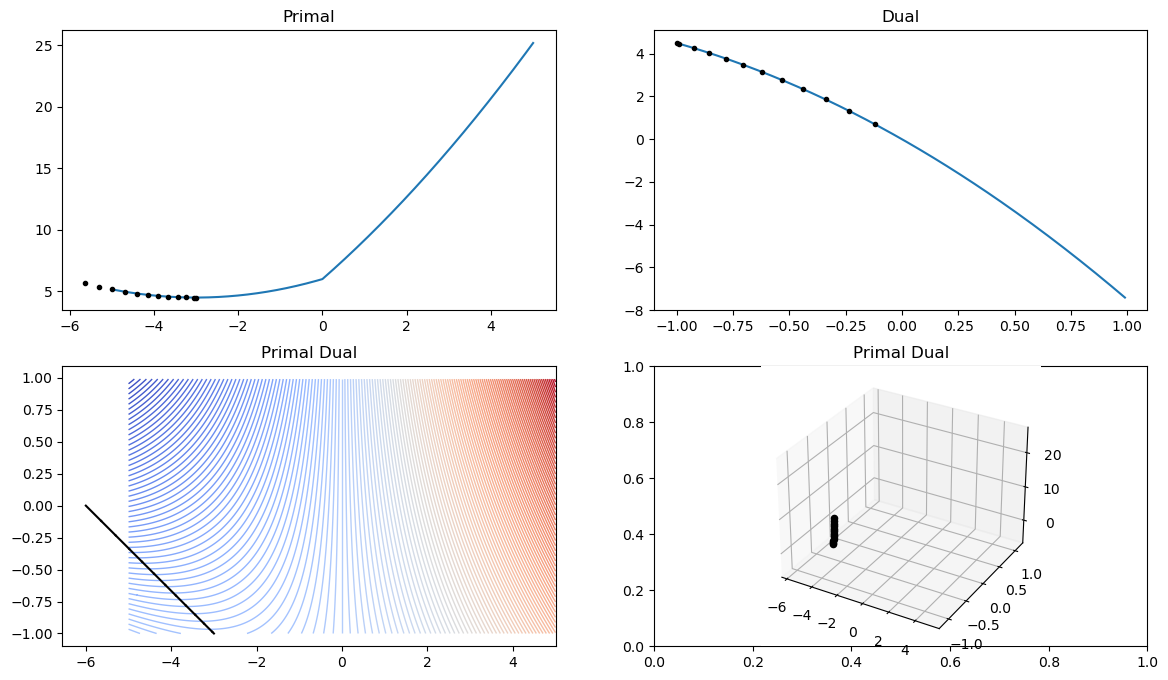

[It. 12 of 1000] |P( x(k) ) - D( y(k) )| = [[0.]]


In [8]:
toy_problem_r1()

In [9]:
def toy_problem_r2():
    # primal mesh to draw primal function
    xx1 = np.matrix(np.arange(start = -15, stop = 10.1, step = .1))
    xx2 = np.matrix(np.arange(start = -10, stop = 15.1, step = .1))
    [x1, x2] = np.meshgrid(xx1, xx2)
    x = np.vstack((x1.T.flatten(), x2.T.flatten()))
    pmg_sz = x1.shape

    # dual mesh to draw dual function
    xy1 = np.matrix(np.arange(start = -1.1, stop = 1.1, step = .01))
    xy2 = np.matrix(np.arange(start = -1.1, stop = 1.1, step = .01))
    [y1, y2] = np.meshgrid(xy1, xy2)
    y = np.vstack((y1.T.flatten(), y2.T.flatten()))
    dmg_sz = y1.shape


    # parameters of primal function
    A = np.matrix([[1, -.5], [-.5, 1]])
    b = np.matrix([[-10], [3]])
    lambda_ = 4

    # compute primal function on primal grid
    Ax = np.dot(A, x)
    E1 = np.sqrt(np.power(Ax, 2).sum(axis = 0))
    E2 = np.power(x - np.tile(b, [1, np.prod(pmg_sz)]), 2).sum(axis = 0)
    E  = np.reshape(E1, pmg_sz).T + (1 / (2 * lambda_)) * np.reshape(E2, pmg_sz).T

    # compute dual function on dual grid
    Aty = np.dot(A.T, y)
    D = np.reshape(np.dot(b.T, Aty) - lambda_ / 2 * np.power(Aty,  2).sum(axis = 0), dmg_sz).T
    D = np.where((np.power(y, 2).sum(axis = 0) > 1).reshape(dmg_sz), np.nan, D)

    # ------- #
    # PLOT 
    # ------- #
    # Make the plots
    
    # NOTE: in this case x and y are two dimensional variables. 
    #       Therefore, G(x,y) is a function of 4 variables and we
    #       cannot plot it. We only plot the primal and the dual 
    #       functions.
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 8))
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    ax1.contour(x1, x2, E, 
            corner_mask = False, levels = 150, 
            linewidths=(1,), cmap = cm.coolwarm)    
    ax2.contour(y1, y2, D, 
                corner_mask = False, levels = 150, 
                linewidths=(1,), cmap = cm.coolwarm)
    ax3.plot_surface(x1, x2, E, cmap=cm.coolwarm,
                     linewidth=0, antialiased=False, 
                     vmax=1)
    ax4.plot_surface(y1, y2, D, cmap=cm.coolwarm,
                     linewidth=0, antialiased=False, 
                     vmax=1)
    ax1.set_title("Primal function")
    ax2.set_title("Dual function")
    ax3.set_title("Primal function")
    ax4.set_title("Dual function")
    
    # primal dual ----------------------------------------------
    pd_prms = {"tolerance": 1e-4,
               "delta": 1e-1,
               "theta": 1e-0,
               "max_iters": 1000}
    x_star, y_star = toy_primal_dual(A, b, lambda_, np.matrix([[5], [-5]]), pd_prms, fig, ax1, ax2, ax3, ax4)
    
    # dual ----------------------------------------------
    input("Press Enter to continue...")
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 8))
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    ax1.contour(x1, x2, E, 
            corner_mask = False, levels = 150, 
            linewidths=(1,), cmap = cm.coolwarm)    
    ax2.contour(y1, y2, D, 
                corner_mask = False, levels = 150, 
                linewidths=(1,), cmap = cm.coolwarm)
    ax3.plot_surface(x1, x2, E, cmap=cm.coolwarm,
                     linewidth=0, antialiased=False, 
                     vmax=1)
    ax4.plot_surface(y1, y2, D, cmap=cm.coolwarm,
                     linewidth=0, antialiased=False, 
                     vmax=1)
    ax1.set_title("Primal function")
    ax2.set_title("Dual function")
    ax3.set_title("Primal function")
    ax4.set_title("Dual function")
    d_prms = {"tolerance": 1e-4,
               "delta": 1e-1,
               "max_iters": 1000}
    x_star, y_star = toy_dual(A, b, lambda_, d_prms, fig, ax1, ax2, ax3, ax4)

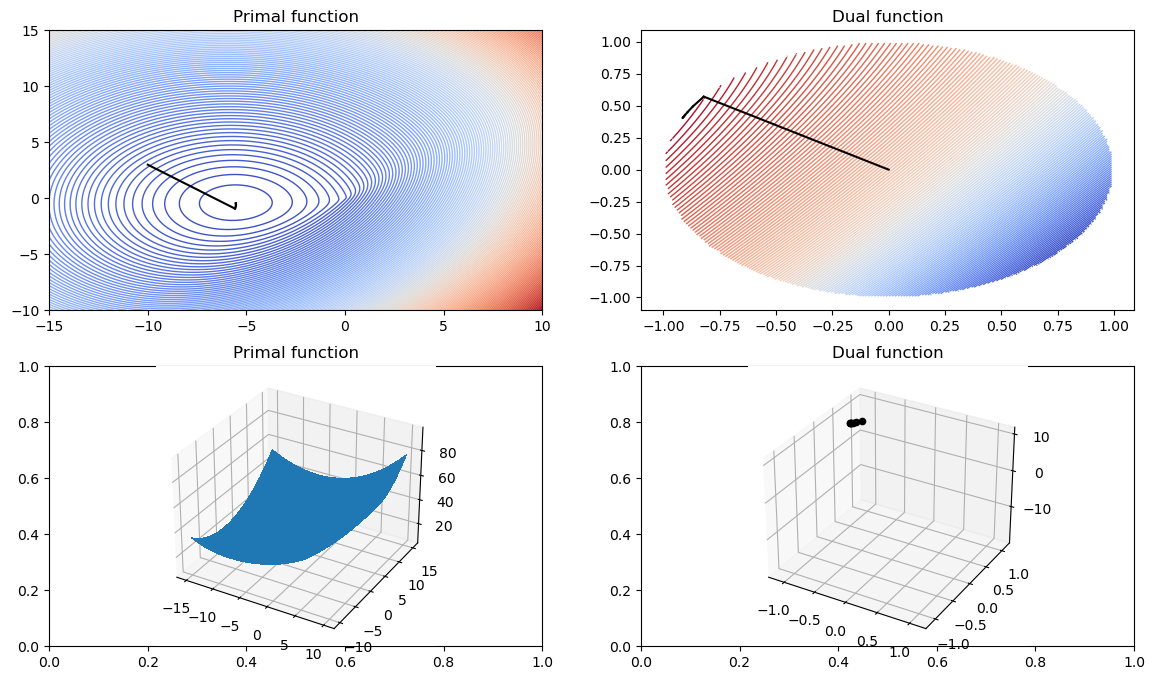

[It. 7 of 1000] |P( x(k) ) - D( y(k) )| = [[6.73831504e-05]]


In [10]:
toy_problem_r2()

**Toy_problem_R1 vs toy_problem_R2**

Both functions are used to minimize the function at the beginning of the lab (using both approaches), but they differ in the exact function that we are minimizing. Since our minimizing functions are generic we can define any matrix and vectors if they don't differ of the assumptions for these variables.

Therefore, in the R1 function we the function depends on just two variables and can be visualized (x and y), but in R2 function, x and y are 2-dimenional variables and we can't plot it since this is equivalent to having 4 variables. Independently of the dimensions, as long as the dimensions are well defined we can apply our minimization algorithms and converge into a solution.


First we solve them with the primal-dual approach and then with the dual one.
There are four plots, the 2 of the upper side are a plot of the primal function on x and the dual function of y respectively. The 2 remaining plots represent the primal-dual funtion on a grid(in one there are the level curves and in the other I think that we should see it in 3D but I could not see anything.
Since our algorithms are iterative, we are able to see each iteration and update of the point with black dots and see how it converges to a minimum of the primal and a maximum of the dual(for both algorithms).

In the R2 we are only able to plot the primal and dual functions, which are now of a higher dimension. There is a 3D plot and a representation of the level curves. Exactly as we did for R1, you can follow the iterations done and how it converges to a maximum of the primal and a minimum of the dual. 

**Algorithm parameters**

Finally for this part of the lab I will change some parameters of the minimization algorithm and study the modification in the algorithm behaviour.



-Initial guess: Initial guess for the algorithm, it will be tend to converge fast if we made better guess.

-Tolerance: tolerance for the stopping condition (it stop when te norm of the gradient is below the tolerance). Chosing very high values it stops at the first iterations but very low values are vey unlikely to stop the algorithm before the iteration limit.

-Max_iters: maximum number of iterations. There isn't an optimal election but either the algorithm diverges(big step size) or converges with time (maybe at every iteration it is falling very near to the minimum but not suficient to stop it) and the use of a limit is very useful to prevent "excessive useless" computations.


-Delta:  gradient ascent step size.
-Theta:  graident descent step size.
With the deafult steps the algorithm finishes close to the optimal point (with the values I tried), but if you make a too big or to little steps in any of the directions the algorithm behaves in a suboptimal way. It is difficult to know which step sizes you should use (without trial an error), but it should a balanced combination of both steps, according to the function we are minimizing each time.


### **1.4 The dual gap and the stopping condition**

Finally note that there is we can derive a precise stopping condition for both the primal-dual and the dual methods. You can find the derivation on the pdf, but we found that the dual gap can be used to bound the error between the current estimation and the actual minimum. Therefore we can use it as criterion for the stopping condition.